In [2]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import csv
import time

def write_to_file(stuff):
    csvFile = open(r'io-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

In [34]:
# This fetches data and writes into csv from our prometheus module. Run it only to get data

# Read data from prometheus
# don't do it if csv is already populated
# to get epoch date --date='Sun 21 Apr 2019 12:25:24 GMT' +"%s"
# end_time = int('1555849524')
# hrs = 7.5
# start_time = int(end_time - 60*60*hrs)
# result = run_query_range(Queries["io_util"], start_time, end_time, 10)
# hosts = {x[0] for x in result}
# response = {}
# for host in hosts:
#     response[host] = [(int(x[1]), float(x[2])) for x in result if x[0]==host]
    
# values = response[Nodes["k8node"]]

# write_to_file(("TIME", "UTIL"))
# XY = []
# for x, y in values:
#     XY.append((x, y))
#     write_to_file( (x, y) )

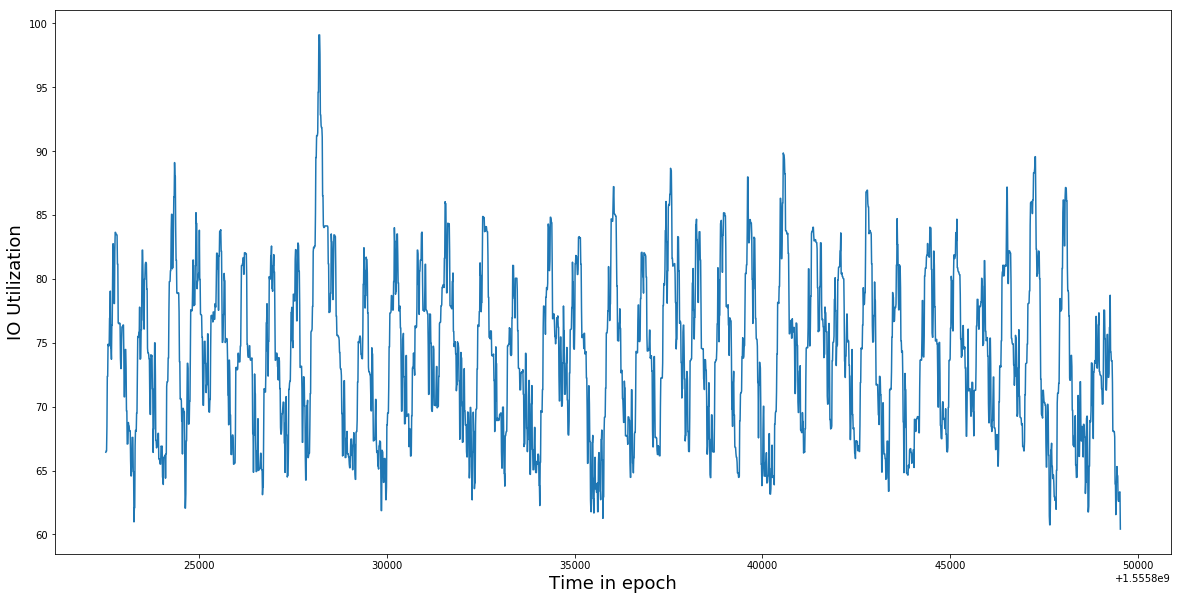

In [218]:
dataframe1 = pd.read_csv('io-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [36]:
import itertools
p=d=q=range(0,10)
pdq = list(itertools.product(p, d, q))
import warnings
warnings.filterwarnings('ignore')
pdqTrunc = [x for x in pdq if x[1] < 5 and x[2] < 5]

In [37]:
aicVal = []
for param in pdqTrunc:
    try:
        model_arima = ARIMA(y1, order=param)
        model_arima_fit = model_arima.fit()
        print(param, model_arima_fit.aic)
        aicVal.append((param, model_arima_fit.aic))
    except:
        continue

(0, 0, 0) 17635.32246231514
(0, 0, 1) 15029.116633440128
(0, 0, 3) 12129.359478044677
(0, 1, 0) 10939.247704975081
(0, 1, 1) 10907.612588954711
(0, 1, 2) 10697.02035162101
(0, 1, 3) 10587.508283659154
(0, 1, 4) 10554.583659140164
(0, 2, 0) 12433.943120772168
(0, 2, 1) 10945.947481900661
(0, 2, 2) 10914.164353361053
(0, 2, 3) 10702.983101781041
(1, 0, 0) 10892.48237963879
(1, 0, 1) 10849.962843382757
(1, 0, 2) 10580.40606952635
(1, 0, 3) 10532.948378499217
(1, 0, 4) 10511.939849801292
(1, 1, 0) 10896.175965353359
(1, 1, 1) 10891.145724464957
(1, 1, 2) 10631.835347687516
(1, 1, 3) 10544.823703592801
(1, 1, 4) 10542.907846079865
(1, 2, 0) 11624.408188803145
(1, 2, 1) 10902.64620706771
(1, 2, 2) 10930.972817216576
(2, 0, 0) 10830.79967516521
(2, 0, 1) 10819.415971621438
(2, 0, 2) 10547.601044381996
(2, 0, 3) 10503.55147807873
(2, 0, 4) 10502.483166853748
(2, 1, 0) 10851.19735626947
(2, 1, 1) 10725.996234745215
(2, 1, 2) 10632.934410509002
(2, 1, 3) 10525.642600576546
(2, 1, 4) 10408.411165

In [40]:
aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1]);

In [45]:
aicVal2[0:10]

[((8, 0, 4), 10207.127994238517),
 ((9, 0, 3), 10216.205135583734),
 ((7, 0, 3), 10217.824192706637),
 ((7, 0, 4), 10218.141290131442),
 ((8, 0, 3), 10218.89206067531),
 ((7, 0, 2), 10219.06090740463),
 ((6, 0, 4), 10219.793880423367),
 ((6, 0, 2), 10222.415969610785),
 ((5, 0, 4), 10223.432734662094),
 ((5, 0, 3), 10224.770911314296)]

In [219]:
split_percent = 0.8448
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

420
2281


In [220]:
predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[i:i+train_samples]
    model_arima = ARIMA(Y_Train, order=(5, 0, 3))
    model_arima_fit = model_arima.fit()
    predictions.append(model_arima_fit.forecast(steps=6)[0][5])

In [223]:
X_Test = []
Y_Test = []
for i in range(6, forecast_time, 6):
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])

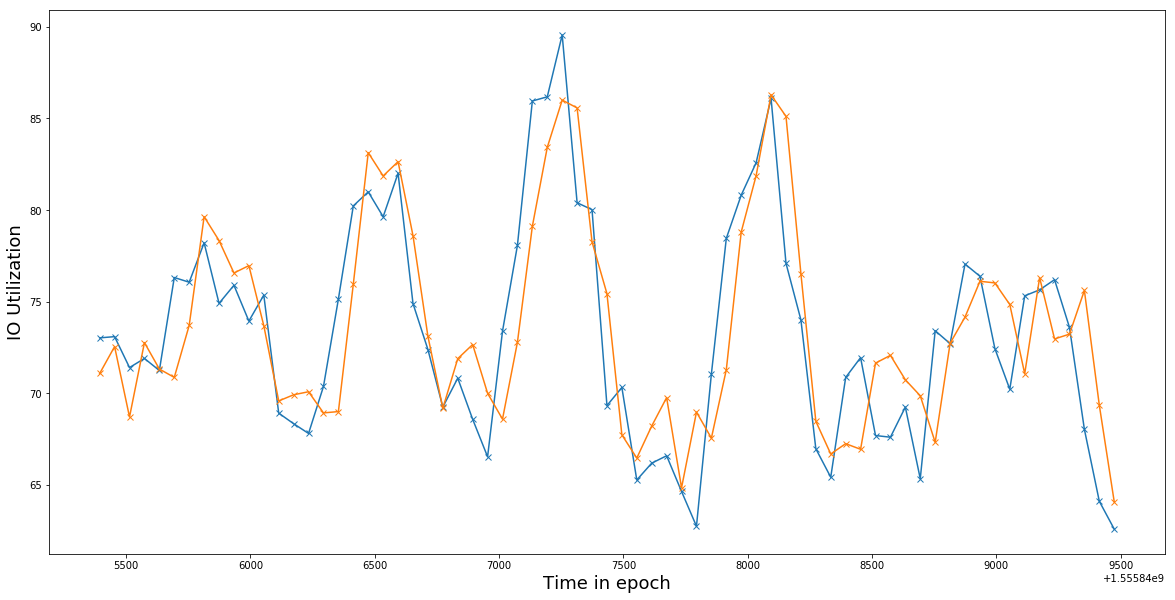

In [224]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, predictions[0:-1], {'marker': 'x'})

In [231]:
Pred = predictions[0:-1]

In [234]:
for i in range(0, 70):
    print(X_Test[i] - 1555840000, Y_Test[i], Pred[i]) 

5394 73.0259649122807 71.08188058644402
5454 73.09192982456139 72.54948098247154
5514 71.40631578947368 68.70885642073823
5574 71.9017543859649 72.76702098447365
5634 71.24631578947368 71.32572934670387
5694 76.31859649122806 70.86828918213294
5754 76.0617543859649 73.70736808118832
5814 78.21192982456141 79.63717473007351
5874 74.90947368421052 78.33619350250537
5934 75.89473684210526 76.5652724224063
5994 73.94245614035087 76.96678918202119
6054 75.35859649122807 73.6911935129883
6114 68.91929824561403 69.58388709230762
6174 68.34245614035089 69.92071786240851
6234 67.81052631578946 70.08569333718006
6294 70.37333333333333 68.93167259381121
6354 75.14245614035087 69.00396455434611
6414 80.22736842105263 75.96091173666342
6474 80.99228070175438 83.12974818170922
6534 79.63368421052631 81.86133032438075
6594 82.00701754385965 82.64078837191641
6654 74.89824561403508 78.60244477894105
6714 72.39017543859649 73.11184811915342
6774 69.24912280701754 69.18574492964092
6834 70.8266666666666

IndexError: list index out of range

In [32]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[i:i+train_samples]
    model_arima = ARIMA(Y_Train, order=(5, 0, 3))
    model_arima_fit = model_arima.fit()
    predictions.append(model_arima_fit.forecast(steps=6)[0][5])

# CPU Util

In [9]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import csv
import time

def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[1m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

def write_to_file_cpu(stuff):
    csvFile = open(r'cpu-util-new.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()

In [10]:
# Read data from prometheus
# don't do it if csv is already populated
# to get epoch date --date='Sun 21 Apr 2019 12:25:24 GMT' +"%s"
# end_time = int('1555699619')
# hrs = 7
# start_time = int(end_time - 60*60*hrs)
# result = run_query_range(Queries["cpu"], start_time, end_time, 10)
# hosts = {x[0] for x in result}
# response = {}
# for host in hosts:
#     response[host] = [(int(x[1]), float(x[2])) for x in result if x[0]==host]
    
# values = response[Nodes["k8master"]]

# write_to_file_cpu(("TIME", "UTIL"))
# XY = []
# for x, y in values:
#     XY.append((x, y))
#     write_to_file_cpu( (x, y) )

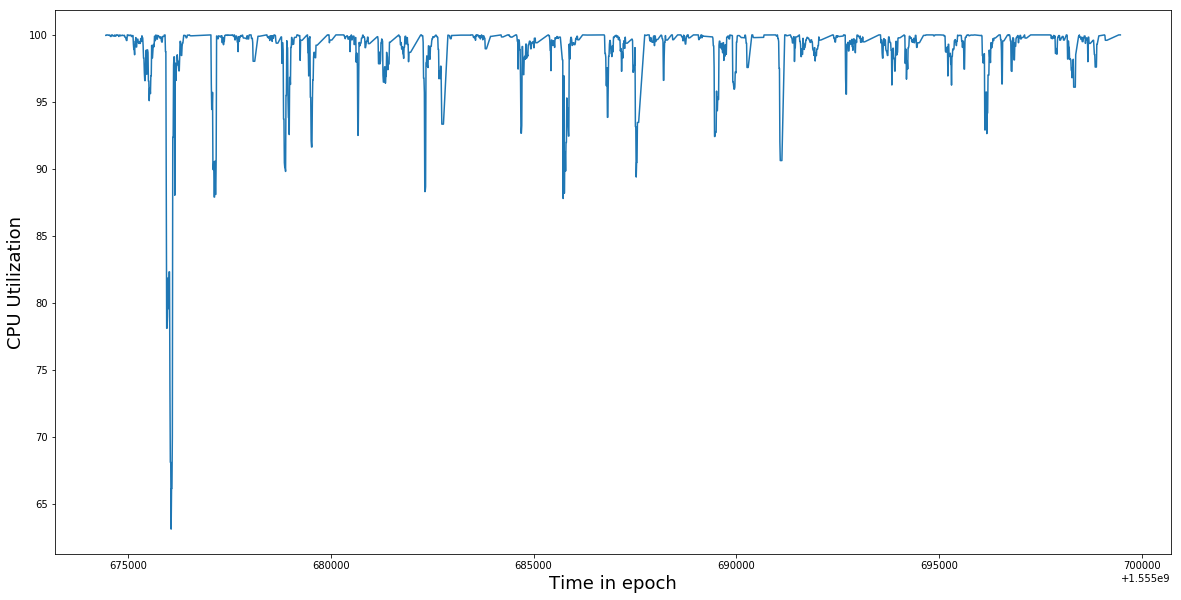

In [12]:
dataframe1 = pd.read_csv('cpu-util-new.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [14]:
import itertools
p=d=q=range(0,8)
pdq = list(itertools.product(p, d, q))
import warnings
warnings.filterwarnings('ignore')
pdqTrunc = [x for x in pdq if x[1] < 5 and x[2] < 5]

In [15]:
aicVal = []
for param in pdqTrunc:
    try:
        model_arima = ARIMA(y1, order=param)
        model_arima_fit = model_arima.fit()
        print(param, model_arima_fit.aic)
        aicVal.append((param, model_arima_fit.aic))
    except:
        continue

(0, 0, 0) 8739.473370042075
(0, 0, 1) 7297.353708260745
(0, 0, 3) 6261.410907240318
(0, 0, 4) 6010.040984430161
(0, 1, 0) 5820.352088132711
(0, 1, 1) 5822.349575345903
(0, 1, 2) 5823.839440896497
(0, 1, 3) 5825.776876392758
(0, 1, 4) 5823.13115295922
(0, 2, 0) 7015.016353725982
(0, 2, 1) 5827.442016487208
(1, 0, 0) 5744.296811036952
(1, 0, 1) 5742.529012304458
(1, 0, 2) 5737.652129790839
(1, 0, 3) 5730.668688920765
(1, 0, 4) 5729.682177090381
(1, 1, 0) 5822.349493497567
(1, 1, 1) 5745.128082103953
(1, 1, 2) 5743.298811817417
(1, 1, 3) 5738.336917175312
(1, 1, 4) 5731.207692784449
(1, 2, 0) 6501.997660845049
(1, 2, 1) 5829.436418664055
(1, 2, 2) 5830.580251214247
(1, 2, 3) 5832.500484770878
(1, 2, 4) 5834.215229619579
(2, 0, 0) 5741.974085507548
(2, 0, 1) 5736.394252935098
(2, 0, 2) 5733.92776027712
(2, 0, 3) 5731.630135083243
(2, 1, 0) 5823.890272301386
(2, 1, 1) 5742.730110441799
(2, 1, 2) 5736.927736442606
(2, 1, 3) 5744.585569085944
(2, 2, 0) 6309.303610827673
(2, 2, 1) 5830.9442702

In [16]:
aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1]);
aicVal2[0:20]

[((5, 0, 4), 5703.580680026953),
 ((6, 0, 4), 5704.126012786546),
 ((7, 0, 4), 5705.960061200567),
 ((3, 1, 3), 5714.94953351039),
 ((3, 0, 3), 5715.666000757397),
 ((4, 0, 2), 5715.677793877188),
 ((4, 0, 3), 5717.259530107984),
 ((4, 0, 4), 5717.829925703708),
 ((4, 1, 4), 5718.04810817926),
 ((3, 0, 4), 5718.048620870754),
 ((5, 0, 2), 5718.391926851913),
 ((5, 1, 3), 5718.930469330992),
 ((5, 0, 3), 5719.016321510536),
 ((6, 1, 3), 5719.305840783943),
 ((6, 0, 3), 5721.30427709944),
 ((7, 0, 3), 5722.482712083203),
 ((6, 0, 0), 5725.635642670938),
 ((6, 1, 1), 5726.295458561149),
 ((6, 0, 1), 5727.630847273634),
 ((7, 0, 0), 5727.635058011145)]

In [17]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

347
1385


In [34]:
predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[i:i+train_samples]
    model_arima = ARIMA(Y_Train, order=(6, 0, 1))
    model_arima_fit = model_arima.fit()
    predictions.append(model_arima_fit.forecast(steps=6)[0][5])

In [35]:
len(predictions)

58

In [36]:
X_Test = []
Y_Test = []
for i in range(6, forecast_time, 6):
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])

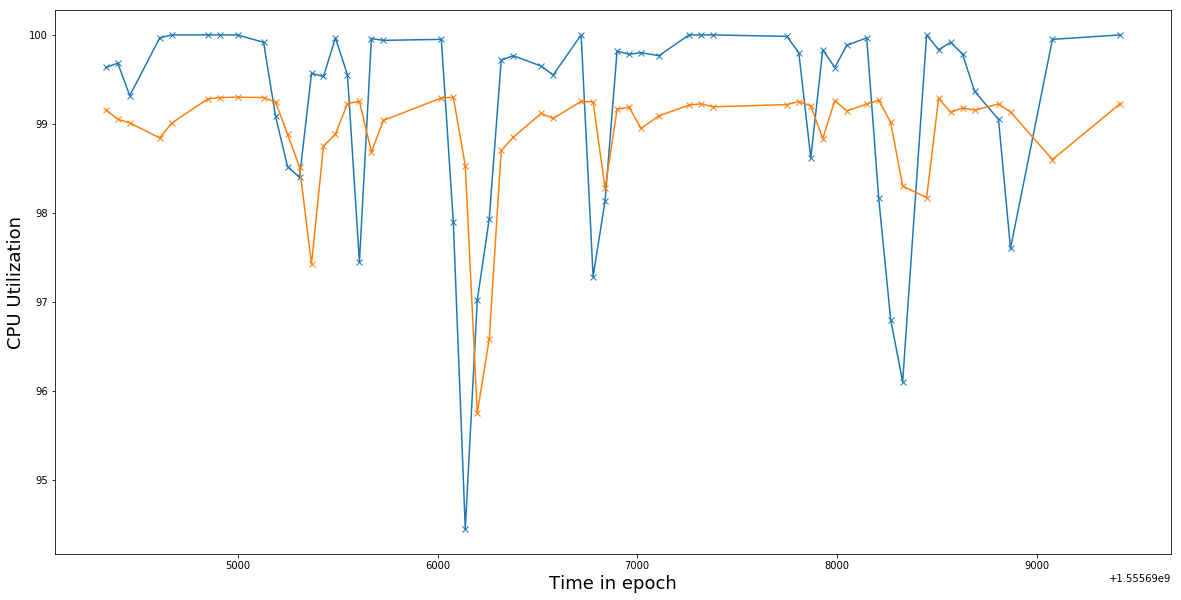

In [37]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, predictions[0:-1], {'marker': 'x'})

In [38]:
mean_absolute_percentage_error(Y_Test, predictions[0:-1])

0.943009525979916

In [45]:
for i in range(0, len(X_Test)):
    print(predictions[i])

99.15788947483101
99.05250734876367
99.01111969002353
98.84117724096211
99.00858751222596
99.27939762645994
99.29579496598967
99.30032294454736
99.2958660772881
99.24484806447494
98.88229814524777
98.51688268293299
97.42571752647115
98.75010074303938
98.88487100482823
99.2277855924308
99.25212312869816
98.68607532332987
99.03808782978507
99.29106927475334
99.29927074232455
98.53050520975326
95.74750453175638
96.58443190705275
98.70099810828427
98.84906351199929
99.11674334522914
99.06115396777386
99.25215370447549
99.24746496158619
98.2732844591326
99.1653791439898
99.18717156223646
98.94854429244957
99.09060806239198
99.21054251326696
99.22545610312835
99.1914316985916
99.21690122916888
99.25072678533144
99.20168003892012
98.83447378932435
99.26134572530525
99.14543303939011
99.22301097445549
99.2644455291811
99.01802410466243
98.30088740393282
98.17000346521901
99.28545666338573
99.13093203014691
99.17858147691749
99.15371384515387
99.22302283473796
99.13368104186644
98.5991010654042

# Memory

In [122]:
def write_to_file_mem(stuff):
    csvFile = open(r'mem-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()

In [123]:
# Read data from prometheus
# don't do it if csv is already populated
# to get epoch date --date='Sun 21 Apr 2019 12:25:24 GMT' +"%s"
# end_time = int('1555597259')
# hrs = 7.5
# start_time = int(end_time - 60*60*hrs)
# result = run_query_range(Queries["mem"], start_time, end_time, 10)
# hosts = {x[0] for x in result}
# response = {}
# for host in hosts:
#     response[host] = [(int(x[1]), float(x[2])) for x in result if x[0]==host]
    
# values = response[Nodes["k8master"]]

# write_to_file_mem(("TIME", "UTIL"))
# XY = []
# for x, y in values:
#     XY.append((x, y))
#     write_to_file_mem( (x, y) )

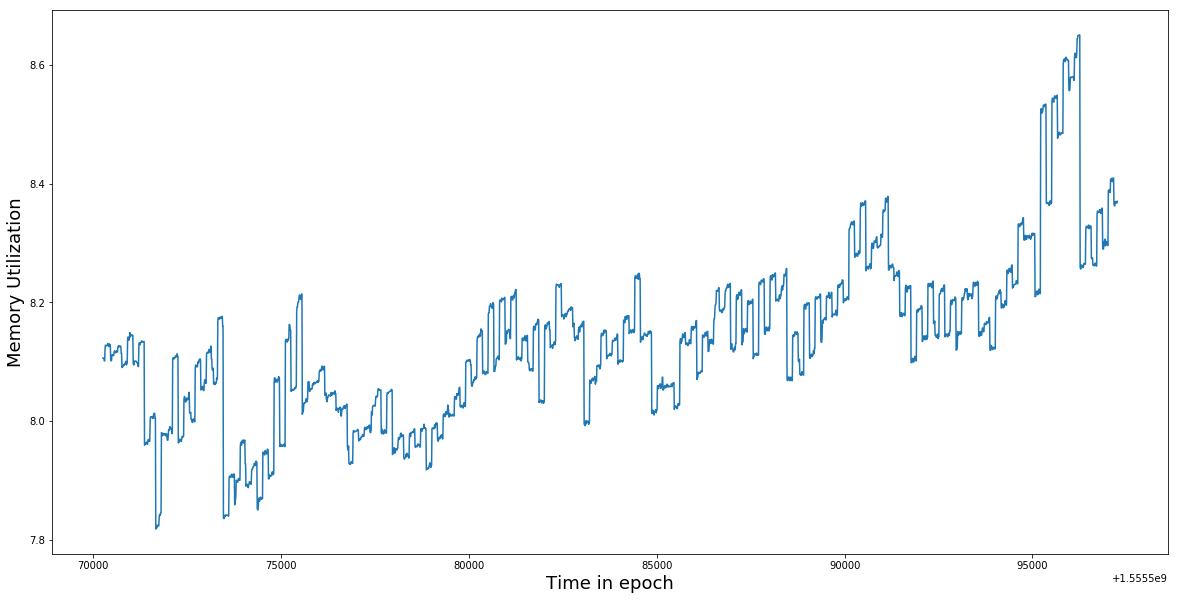

In [205]:
dataframe1 = pd.read_csv('mem-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('Memory Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [206]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

541
2160


In [126]:
import itertools
p=d=q=range(0,9)
pdq = list(itertools.product(p, d, q))
import warnings
warnings.filterwarnings('ignore')
pdqTrunc = [x for x in pdq if x[1] < 5 and x[2] < 5]

In [127]:
aicVal = []
for param in pdqTrunc:
    try:
        model_arima = ARIMA(y1, order=param)
        model_arima_fit = model_arima.fit()
        print(param, model_arima_fit.aic)
        aicVal.append((param, model_arima_fit.aic))
    except:
        continue

(0, 0, 0) -2995.418064976566
(0, 0, 1) -6046.061510700477
(0, 0, 4) -10402.873165332705
(0, 1, 0) -12665.271904350664
(0, 1, 1) -12663.598502747176
(0, 1, 2) -12661.623714497626
(0, 1, 3) -12666.486303557107
(0, 1, 4) -12664.631287027216
(0, 2, 0) -10818.706924447632
(0, 2, 1) -12649.76590118181
(0, 2, 2) -12648.112149128141
(1, 0, 0) -12682.764086765088
(1, 0, 1) -12681.632302390524
(1, 0, 2) -12679.96137323861
(1, 0, 3) -12683.047149383096
(1, 0, 4) -12681.0526085589
(1, 1, 0) -12663.600053909362
(1, 1, 1) -12661.60081932764
(1, 1, 3) -12664.604173822008
(1, 1, 4) -12662.631430673464
(1, 2, 0) -11576.32236891782
(1, 2, 1) -12648.11369048466
(1, 2, 2) -12757.901085766262
(1, 2, 3) -12684.436275351061
(1, 2, 4) -12783.47103911607
(2, 0, 0) -12681.649834984586
(2, 0, 1) -12679.685822122934
(2, 0, 2) -12813.87480844008
(2, 0, 3) -12681.05119035947
(2, 0, 4) -12679.053809124911
(2, 1, 0) -12661.608177736074
(2, 1, 1) -12699.531309736336
(2, 1, 2) -5759.312421120731
(2, 1, 3) -12938.575069

In [128]:
aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1]);
aicVal2[0:20]

[((4, 0, 3), -13064.346724037841),
 ((3, 0, 4), -12966.075438266955),
 ((4, 1, 2), -12945.279421432322),
 ((3, 1, 2), -12944.584016063618),
 ((2, 1, 3), -12938.575069620645),
 ((3, 0, 1), -12817.263135708767),
 ((2, 0, 2), -12813.87480844008),
 ((3, 1, 4), -12811.12741328148),
 ((1, 2, 4), -12783.47103911607),
 ((3, 2, 2), -12783.27593621708),
 ((2, 2, 2), -12781.40292528574),
 ((1, 2, 2), -12757.901085766262),
 ((3, 0, 2), -12744.603334172127),
 ((2, 1, 4), -12729.825466470189),
 ((2, 1, 1), -12699.531309736336),
 ((3, 2, 3), -12687.848330004792),
 ((1, 2, 3), -12684.436275351061),
 ((4, 0, 0), -12683.588550684173),
 ((1, 0, 3), -12683.047149383096),
 ((1, 0, 0), -12682.764086765088)]

In [207]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

541
2160


In [208]:
predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[i:i+train_samples]
    model_arima = ARIMA(Y_Train, order=(0, 1, 2))
    model_arima_fit = model_arima.fit()
    predictions.append(model_arima_fit.forecast(steps=6)[0][5])

In [213]:
predictions;

In [214]:
X_Test = []
Y_Test = []
for i in range(6, forecast_time, 6):
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])


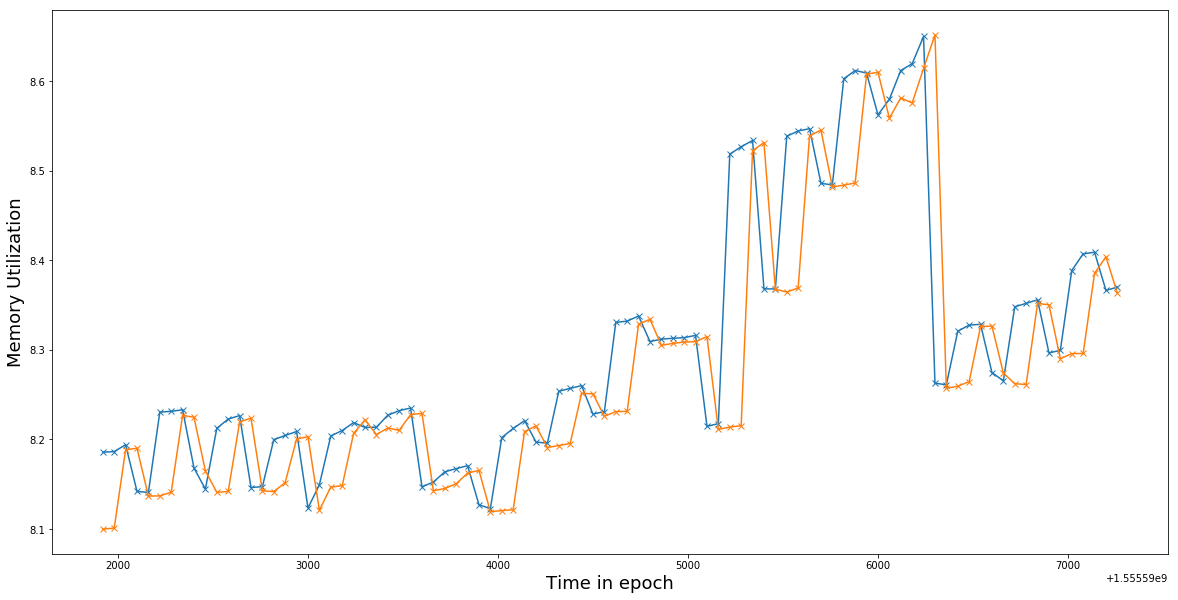

In [215]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('Memory Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, predictions[0:-1], {'marker': 'x'})

In [216]:
mean_absolute_percentage_error(Y_Test, predictions[0:-1])

0.638290811625705

In [217]:
predictions[0:-1]

[8.100016393912348,
 8.101105199896677,
 8.188603927439273,
 8.190242654490199,
 8.136852925206394,
 8.137052959428368,
 8.141202896684861,
 8.226918119351835,
 8.224855622142526,
 8.164824320231101,
 8.141077658237524,
 8.141969674435462,
 8.219459552017314,
 8.223994168920518,
 8.142703513971199,
 8.141896572597743,
 8.151955814685527,
 8.200628685547738,
 8.203015676114115,
 8.120988897467752,
 8.146956626013495,
 8.14832954475696,
 8.20672805443662,
 8.221976087225524,
 8.205529347282617,
 8.212786530725472,
 8.210270738864855,
 8.227663096204422,
 8.229210223563067,
 8.142824413211798,
 8.145326100555902,
 8.150618594373425,
 8.162478346620299,
 8.165490906233284,
 8.11941785824902,
 8.120678444571451,
 8.121617554047551,
 8.208918880712536,
 8.215127805476737,
 8.191018274827847,
 8.193205987385394,
 8.195514394054813,
 8.251551110833253,
 8.250980655841223,
 8.225864850973975,
 8.231131869634833,
 8.231354083871862,
 8.328711229060962,
 8.334146584439111,
 8.305141891945908,
 8.